# Task 6: Forecasting Future Sales
# Author: Syed Huzaifa Bin Khamis | Nexus AI Digital Internship

# 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 2. Load & Prepare Data


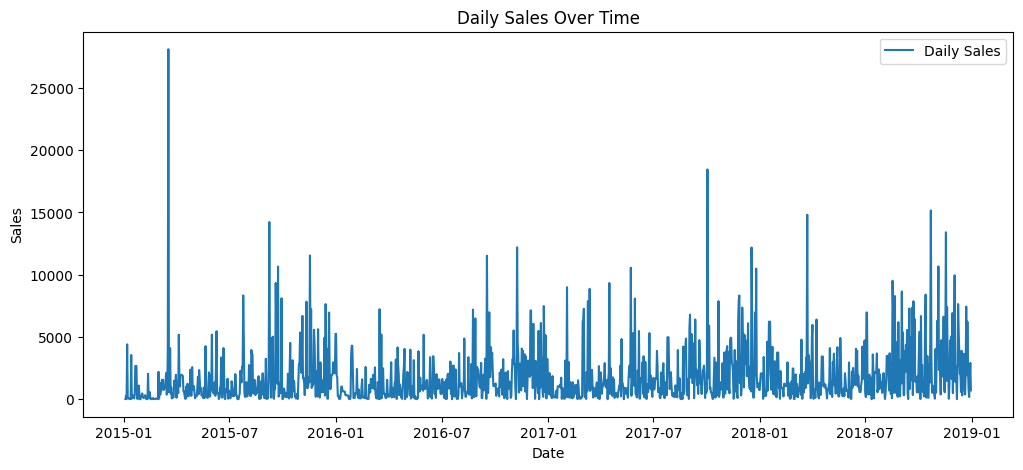

In [2]:
# Load dataset with correct parsing of dates (dayfirst=True for DD/MM/YYYY format)
data = pd.read_csv("train.csv", parse_dates=["Order Date"], dayfirst=True)

# Aggregate sales by date
sales = data.groupby("Order Date")["Sales"].sum().reset_index()

# Set date as index
sales.set_index("Order Date", inplace=True)
sales = sales.asfreq("D")   # set daily frequency
sales = sales.ffill()       # forward fill missing values

# Plot sales
plt.figure(figsize=(12,5))
plt.plot(sales, label="Daily Sales")
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# 3. Check Stationarity

In [3]:
result = adfuller(sales["Sales"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is non-stationary → applying differencing")
    sales_diff = sales.diff().dropna()
else:
    print("Data is stationary")
    sales_diff = sales

ADF Statistic: -6.251366350804219
p-value: 4.44577042659461e-08
Data is stationary


# 4. Train SARIMA Model

In [4]:
# Simple (p,d,q)(P,D,Q,s) values chosen as example, you can tune via grid search
model = SARIMAX(sales["Sales"], 
                order=(1,1,1), 
                seasonal_order=(1,1,1,7),  # weekly seasonality
                enforce_stationarity=False, 
                enforce_invertibility=False)

sarima_fit = model.fit(disp=False)
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1458
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13087.444
Date:                           Fri, 03 Oct 2025   AIC                          26184.887
Time:                                   21:39:17   BIC                          26211.253
Sample:                               01-03-2015   HQIC                         26194.729
                                    - 12-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1030      0.022      4.718      0.000       0.060       0.146
ma.L1         -0.9714      0.008   -128.269

# 5. Forecast Next 30 Days

In [5]:
forecast = sarima_fit.get_forecast(steps=30)
forecast_index = pd.date_range(sales.index[-1] + pd.Timedelta(days=1), periods=30, freq="D")

forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
conf_int = forecast.conf_int()
conf_int.index = forecast_index

# 6. Visualization


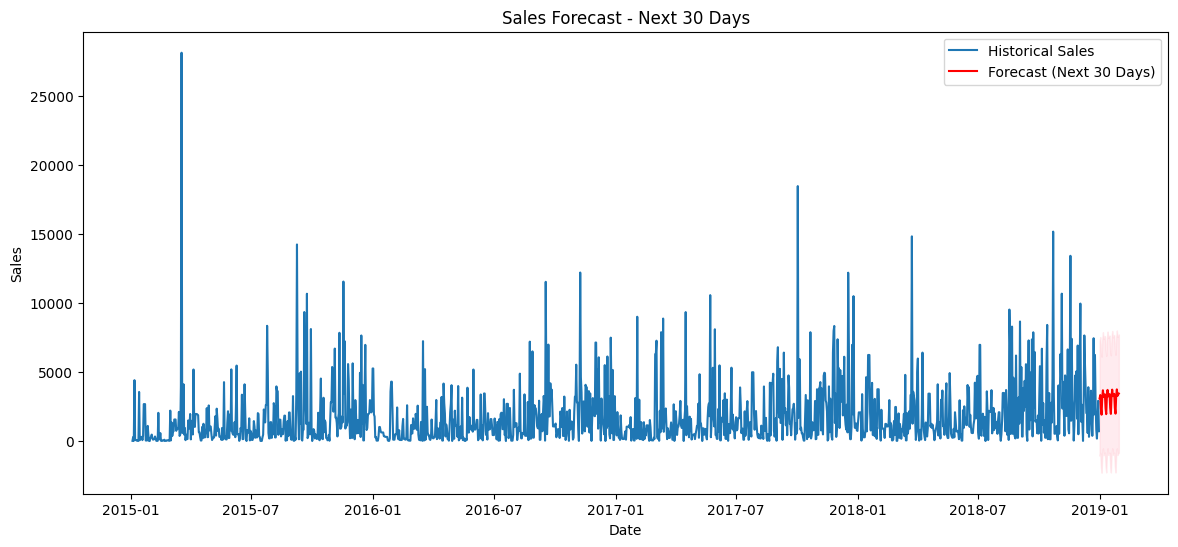

In [6]:
plt.figure(figsize=(14,6))
plt.plot(sales, label="Historical Sales")
plt.plot(forecast_series, label="Forecast (Next 30 Days)", color="red")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1], color="pink", alpha=0.3)

plt.title("Sales Forecast - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()